## How to run code

#### 1. Declare all classes and common functions
#####      - Classes: Layer, Optimizer, Loss, MLP
#####      - Functions: f1_score (evaluation), mini_batch (use to make batches)
#### 2. Load the train and test data (including split train data into train and validation)
#### 3. Create a model
#### 4. Train a model
#### 5. Make a prediction
#### 6. Evaluate results

In [1]:
# import packages
import numpy as np
from scipy.stats import bernoulli
import pandas as pd
import seaborn as sns

#### Linear Layer, ReLULayer, SoftMaxLayer, BatchNormalizationLayer, DropOutLayer, SigmoidLayer(unused)
## Define Layers

In [2]:
class Layer:

    # abstract class for layers

    def forward(self, x: np.ndarray, train_flag=True):
        pass

    def backward(self, delta: np.ndarray):
        pass

class LinearLayer(Layer):
    # Linear Layer
    # output(y) = input(x) @ w + b

    input: np.ndarray
    output: np.ndarray
    weight: np.ndarray
    bias: np.ndarray
    delta: np.ndarray

    weight_grad: np.ndarray
    bias_grad: np.ndarray

    def __init__(self, input_size, output_size):

        # Randomly assign small values for the weights as the initialization
        self.weight = np.random.uniform(
            # initialization (He) for ReLU, Kaiming_uniform
            high = np.sqrt(6. / input_size),
            low = -np.sqrt(6. / input_size),
            size = (input_size, output_size)
        )

        # Initialize bias, delta
        self.bias = np.zeros(output_size,)
        self.delta = np.zeros(output_size,)

        # Initialize weight_grad, bias_grad
        self.weight_grad = np.zeros((input_size, output_size))
        self.bias_grad = np.zeros(output_size,)

    def forward(self, x:np.ndarray, train_flag=True):
        if not isinstance(x, np.ndarray):
            raise RuntimeError("input x must be a numpy array")

        self.input = x

        # Propagate inputs through the network
        # y = w^t @ x + b = x @ w + b
        self.output = np.dot(x, self.weight) + self.bias

        return self.output

    def backward(self, delta):
        # backward propagation

        # calculate gradient and delta
        self.weight_grad += np.atleast_2d(self.input).T @ np.atleast_2d(delta)
        self.bias_grad += np.sum(delta, axis=0)
        self.delta = delta

        return delta @ self.weight.T

    def update(self, weight, bias):
        # update parameters (wight and bias)
        self.weight = weight
        self.bias = bias

    def zero_grad(self):
        # set gradient to 0
        self.weight_grad.fill(0)
        self.bias_grad.fill(0)

class ReLULayer(Layer):

    # ReLU Layer (Activation)

    def __init__(self):
        # save for backward
        self.out = np.zeros(0)

    def forward(self, x: np.ndarray, train_flag=True):
        # forward propagation
        # input <= 0 then ouput = 0, input > 0 then output = input
        self.out = np.maximum(0, x)
        return self.out

    def backward(self, delta: np.ndarray):
        # backward propagation of ReLU
        return np.where(self.out > 0, 1, 0) * delta

class SoftMaxLayer(Layer):
    # Softmax Layer (Activation)

    def forward(self, x: np.ndarray, train_flag=True):
        exp_x = np.exp(x - np.max(x))
        out = exp_x / np.atleast_2d(np.sum(exp_x, 1)).T
        return out

    def backward(self, delta: np.ndarray):
        # include cross-entropy loss
        return delta

class SigmoidLayer(Layer):

    # Sigmoid Layer (not used)

    def forward(self, x: np.ndarray, train_flag=True):
        return 1 / (1 + np.exp(-x))

    def backward(self, delta: np.ndarray):
        return delta * (1 - delta)

class BatchNormalizationLayer(Layer):
    # Batch Normalization Layer

    def __init__(self, intput_size: int, momentum=0.9, eps=1e-8):

        self.momentum = momentum # for calculating moving average
        self.eps = eps

        self.gamma = np.ones((1, intput_size), dtype="float32")
        self.beta = np.zeros((1, intput_size), dtype="float32")

        self.running_mu = np.zeros(0)
        self.running_var = np.zeros(0)

        # for forward
        self.mu = np.zeros(0)
        self.var = np.zeros(0)
        self.std = np.zeros(0)

        self.x_minus_mu = np.zeros(0)
        self.x_norm = np.zeros(0)

        # for backward
        self.batch_size = None
        self.d_gamma = np.zeros(0)
        self.d_beta = np.zeros(0)

    def update_running_variables(self):

        # update running mu and var, used for prediction
        is_mu_empty = np.array_equal(np.zeros(0), self.running_mu)
        is_var_empty = np.array_equal(np.zeros(0), self.running_var)
        if is_mu_empty != is_var_empty:
            raise ValueError("mean and var should be initialized simultaneously")

        if is_mu_empty:
            self.running_mu = self.mu
            self.running_var = self.var
        else:
            # cannot store all mean & various of batches -> using moving average
            self.running_mu = self.momentum * self.running_mu + (1 - self.momentum) * self.mu
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var

    def forward(self, x: np.ndarray, train_flag=True):

        if train_flag:
            # if it is training, use batch data to caculate normalized x
            self.mu = np.mean(x, axis=0)
            self.x_minus_mu = x - self.mu
            self.var = np.mean(self.x_minus_mu**2, axis=0)
            self.std = np.sqrt(self.var + self.eps)
            x_norm = self.x_minus_mu / self.std

            self.batch_size = x.shape[0]
            self.x_norm = x_norm

            self.update_running_variables()
        else:
            # if it is not training, use running values to calculate normalized x
            x_minus_mu = x - self.running_mu
            x_norm = x_minus_mu / (np.sqrt(self.running_var + self.eps))

        return self.gamma * x_norm + self.beta

    def backward(self, d_out: np.ndarray) -> np.ndarray:
        # calculate gradient

        self.d_beta = np.sum(d_out, axis=0)
        self.d_gamma = np.sum(d_out * self.x_norm, axis=0)

        d_x_norm = d_out * self.gamma
        d_x_minus_mu1 = d_x_norm / self.std

        d_std = -np.sum((d_x_norm * self.x_minus_mu) / (self.std**2), axis=0)
        d_var = 0.5 * d_std / self.std

        d_x_minus_mu2 = (2 / self.batch_size) * self.x_minus_mu * d_var

        d_x1 = d_x_minus_mu1 + d_x_minus_mu2

        d_mu = -1 * np.sum(d_x_minus_mu1 + d_x_minus_mu2, axis=0)
        d_x2 = d_mu  / self.batch_size

        d_x = d_x1 + d_x2

        return d_x

    def update(self, learning_rate):
        # update parameters (gamma, beta)
        self.gamma -= learning_rate * self.d_gamma
        self.beta -= learning_rate * self.d_beta

    def zero_grad(self):
        # set gradient to 0
        self.d_gamma.fill(0)
        self.d_beta.fill(0)

class DropOutLayer(Layer):
    # Dropout Layer
    # Dropout neurons using bernoulli random variable

    def __init__(self, dropout_ratio=0.6):
        self.mask = None
        self.present_ratio = 1.0 - dropout_ratio

    def forward(self, x, train_flag=True):
        if train_flag:
            # if it is training, do droupout

            # dropout using bernoulli random variable
            self.mask = (bernoulli.rvs(size=x.shape[0] * x.shape[1], p=self.present_ratio)).reshape(*x.shape)

            # weights are scaled-up by a factor of 1/𝑝, present with probability p, p = 1 - dropout_ratio
            return x * self.mask / self.present_ratio
        else:
            # if it is not training, do not droupout
            return x * self.present_ratio

    def backward(self, dout):
        # also drop and scale up in backward propagation
        return dout * self.mask / self.present_ratio

## Define Optimizers
#### SGD, Momentum (with weight decay), Adam (with weight decay)

In [3]:
class Optimizer:

    # Optimizer Layer
    # step(): update parameters
    # zero_grad: initialize gradient to zero

    def __init__(self, model):

        if not isinstance(model, MLP):
            raise RuntimeError("Use only MLP model")

        self.model = model

        return

    def zero_grad(self):
        pass

    def step(self):
        pass

class SGD(Optimizer):
    # Stochastic Gradient Descent (not used)

    learning_rate: float

    def __init__(self, model, learning_rate=0.1):
        super(SGD, self).__init__(model)
        self.learning_rate = learning_rate

    def step(self):
        # update parameters
        for layer in self.model.hidden_layers:
            # update parameters, θ = θ - η * gradient
            weight = layer.weight - self.learning_rate * layer.weight_grad
            bias = layer.bias - self.learning_rate * layer.bias_grad
            layer.update(weight, bias)

    def zero_grad(self):
        # set gradient to 0
        for layer in self.model.hidden_layers:
            if isinstance(layer, LinearLayer) or isinstance(layer, BatchNormalizationLayer):
                layer.zero_grad()
        return

class Momentum(Optimizer):
    # Momentum Optimizer

    def __init__(self, model, learning_rate=0.1, momentum=0.9, weight_decay=0):
        super(Momentum, self).__init__(model)
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weight_decay = weight_decay

        # initialize v_t
        self.v = []
        for layer in self.model.hidden_layers:
            # A Optimizer works for only Linear Layer
            if isinstance(layer, LinearLayer):
                self.v.append({'weight': np.zeros_like(layer.weight), 'bias': np.zeros_like(layer.bias)})
            else:
                self.v.append(None)

        return

    def step(self):
        for idx, layer in enumerate(self.model.hidden_layers):
            if isinstance(layer, LinearLayer):
                # update parameters of linear layer (weight, bias)

                # compute v_t of weight and bias, v_t = γ * v_t-1 + η * gradient
                self.v[idx]['weight'] = self.momentum * self.v[idx]['weight'] + self.learning_rate * layer.weight_grad
                self.v[idx]['bias'] = self.momentum * self.v[idx]['bias'] + self.learning_rate * layer.bias

                # update network, θ = θ - v_t
                # weight decay: θ = (1 - ηα) * θ - η * gradient = (1 - ηα) * θ - v_t
                weight = (1 - self.learning_rate * self.weight_decay) * layer.weight - self.v[idx]['weight']
                bias = (1 - self.learning_rate * self.weight_decay) * layer.bias - self.v[idx]['bias']

                layer.update(weight, bias)

            if isinstance(layer, BatchNormalizationLayer):
                # update parameters of BatchNormalization layer (gamma, beta)
                layer.update(self.learning_rate)

    def zero_grad(self):
        # initialize gradient
        for layer in self.model.hidden_layers:
            if isinstance(layer, LinearLayer) or isinstance(layer, BatchNormalizationLayer):
                layer.zero_grad()

        # initialize v
        for v in self.v:
            if not v is None:
                v['weight'].fill(0)
                v['bias'].fill(0)

        return

class Adam(Optimizer):
    # ADAM(adaptive moment estimation) Optimizer

    def __init__(self, model, learning_rate, beta1=0.9, beta2=0.999, weight_decay=0, eps=1e-08):
        super(Adam, self).__init__(model)
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # initialize m, v, t
        self.m = []
        self.v = []
        self.t = []

        for layer in self.model.hidden_layers:
            # A Optimizer works for only Linear Layer
            if isinstance(layer, LinearLayer):
                self.m.append({'weight': np.zeros_like(layer.weight), 'bias': np.zeros_like(layer.bias)})
                self.v.append({'weight': np.zeros_like(layer.weight), 'bias': np.zeros_like(layer.bias)})
                self.t.append(1)
            else:
                self.m.append(None)
                self.v.append(None)
                self.t.append(None)

    def step(self):
        # update parameters
        # (weight, bias) for linear, (gamma, beta) for batch normalization

        for idx, layer in enumerate(self.model.hidden_layers):
            if isinstance(layer, LinearLayer):
                # update weight and bias
                m_hat = {}
                v_hat = {}

                # calculate m_t, m_t_hat for weight
                self.m[idx]['weight'] = self.beta1 * self.m[idx]['weight'] + (1 - self.beta1) * layer.weight_grad
                self.v[idx]['weight'] = self.beta2 * self.v[idx]['weight'] + (1 - self.beta2) * layer.weight_grad**2
                m_hat['weight'] = self.m[idx]['weight'] / (1 - self.beta1**self.t[idx])
                v_hat['weight'] = self.v[idx]['weight'] / (1 - self.beta2**self.t[idx])
                # calculate m_t, m_t_hat for bias
                self.m[idx]['bias'] = self.beta1 * self.m[idx]['bias'] + (1 - self.beta1) * layer.bias_grad
                self.v[idx]['bias'] = self.beta2 * self.v[idx]['bias'] + (1 - self.beta2) * layer.bias_grad**2
                m_hat['bias'] = self.m[idx]['bias'] / (1 - self.beta1**self.t[idx])
                v_hat['bias'] = self.v[idx]['bias'] / (1 - self.beta2**self.t[idx])

                # calculate gradient
                # update network, θ = θ - η * m_t / sqrt(v_t + e)
                # weight decay: θ = (1 - ηα) * θ - η * gradient = (1 - ηα) * θ - η * m_t / sqrt(v_t + e)
                grad_weight = m_hat['weight'] / np.sqrt(v_hat['weight'] + self.eps)
                grad_bias = m_hat['bias'] / np.sqrt(v_hat['bias'] + self.eps)

                # gradient clipping for weight and bias
                norm_weight = np.linalg.norm(grad_weight)
                if norm_weight > 1.0:
                    grad_weight = grad_weight * (1.0 / norm_weight)
                norm_bias = np.linalg.norm(grad_weight)
                if norm_bias > 1.0:
                    grad_weight = grad_weight * (1.0 / norm_bias)

                # update weight and bias of linear layer
                weight = (1 - self.learning_rate * self.weight_decay) * layer.weight - self.learning_rate * grad_weight
                bias = (1 - self.learning_rate * self.weight_decay) * layer.bias - self.learning_rate * grad_bias
                layer.update(weight, bias)

                self.t[idx] += 1

            if isinstance(layer, BatchNormalizationLayer):
                # update gamma and beta of batch normalization layer
                layer.update(self.learning_rate)

    def zero_grad(self):
        # initialize gradients of layers
        for layer in self.model.hidden_layers:
            if isinstance(layer, LinearLayer) or isinstance(layer, BatchNormalizationLayer):
                layer.zero_grad()

        # initialize m, v, t
        for i in range(len(self.m)):
            if not self.m[i] is None:
                self.m[i]['weight'].fill(0)
                self.m[i]['bias'].fill(0)

            if not self.v[i] is None:
                self.v[i]['weight'].fill(0)
                self.v[i]['bias'].fill(0)

            self.t[i] = 1

## Define
#### Cross-Entropy Loss

In [4]:
class Loss:
    # class for loss function

    loss: int
    delta: np.ndarray

    def __init__(self, model):
        if not isinstance(model, MLP):
            raise RuntimeError("Use only MLP model")

        self.model = model
        return

    def backward(self):
        self.model.backward(self.delta)

class CrossEntropyLoss(Loss):
    # Cross-Entropy Loss
    # Backward propagation includes softmax for computing efficiency, delta = y_hat - y

    def __init__(self, model, y_hat, y, is_one_hot=False, eps=1e-8):
        super(CrossEntropyLoss, self).__init__(model)
        self.eps = eps

        if is_one_hot:
            # if format of y is one-hot encoding
            # compute loss
            self.loss = -np.sum(y * np.log(y_hat + self.eps)) / (y.shape[0])

            # Compute delta of output layer
            self.delta = y_hat - y
            self.delta /= np.atleast_2d(y_hat).shape[0]
        else:
            # if format of y is not one-hot encoding
            if y_hat.ndim ==1:
                y_hat = np.atleast_2d(y_hat)
                y = np.atleast_2d(y)
            # compute loss
            self.loss = -np.sum(np.log(y_hat[np.arange(y_hat.shape[0]),y] + self.eps)) / y_hat.shape[0]

            # Compute delta of output layer (for softmax cross-entropy: y_hat - y)
            # actual y value is always 0 or 1, but y value in this function has a label value between 0 and 9 (not one-hot encoding)
            # so, use y as an index and subtract 1 from y_hat[y].
            self.delta = np.copy(y_hat)
            self.delta[np.arange(y_hat.shape[0]), y] -= 1
            self.delta /= np.atleast_2d(y_hat).shape[0]

        return

    def get_loss(self):
        # return loss
        return self.loss

## Define Multi Layer Perceptron Class

In [5]:
# MLP model
class MLP:
    # class for Multi Layer Perceptron Model

    hidden_layers: list # e.g. linear, activation, batch normalization, dropout
    parameters: list # for model saving and loading during early stopping in training

    def __init__(self, layers: list):
        self.hidden_layers = layers
        self.parameters = []
        return

    def forward(self, x, train_flag=True):
        # forward propagate inputs through the network
        for i in range(len(self.hidden_layers)):
            x = self.hidden_layers[i].forward(x, train_flag=train_flag)

        return x

    def backward(self, delta):
        # backward propagation
        for i in reversed(range(len(self.hidden_layers))):
            delta = self.hidden_layers[i].backward(delta)

    def train(self, x_train:np.ndarray, y_train:np.ndarray, x_valid:np.ndarray, y_valid:np.ndarray, epochs=100,
              optimizer='momentum', learning_rate=0.001, momentum=0, weight_decay=0, patience=15, verbose=2):
        # train a model

        loss_fn = CrossEntropyLoss # set loss function
        batch_size = 32 # set batch size
        n_batch = int(np.ceil(x_train.shape[0]/batch_size)) # calculate a number of batches

        # set a optimizer according to input
        if optimizer == 'momentum':
            optimizer = Momentum(model=self, learning_rate=learning_rate, momentum=momentum)
        elif optimizer == 'adam':
            optimizer = Adam(model=self, learning_rate=learning_rate)
        else:
            optimizer = SGD(model=self, learning_rate=learning_rate)

        # initialize values for training
        patience_cnt = 0
        best_train_loss = 9999
        best_train_acc = 0
        best_valid_loss = 9999
        best_valid_acc = 0
        best_epoch = 0

        for epoch in range(1, epochs+1):

            loss_sum = 0    # use to calculate total loss, loss = loss_sum / batch_size
            match_cnt = 0   # use to calculate accuracy, accuracy = match_cnt / # of total

            for x_batch, y_batch in iterate_mini_batch(x_train, y_train, batch_size, shuffle=True):

                y_hat = self.forward(x_batch, train_flag=True) # forward
                loss = loss_fn(self, y_hat, y_batch) # loss
                loss_sum += loss.get_loss() # add loss
                match_cnt += np.sum((y_hat.argmax(1)==y_batch)) # add a number of correct y_hat
                loss.backward() # backward

                optimizer.step() # update parameters
                optimizer.zero_grad() # initialize gradients

            # stop if the model does not get better, compare to validation
            y_hat_valid = self.predict(x_valid) # predict using validation data set

            # calculate current loss and accuracy of train and validation
            curr_train_loss = loss_sum / n_batch
            curr_train_acc = match_cnt / y_train.shape[0]
            curr_valid_loss = loss_fn(self, y_hat_valid, y_valid).get_loss()
            curr_valid_acc = np.mean(y_hat_valid.argmax(1)==y_valid)

            if curr_valid_loss >= best_valid_loss:
                # if the loss increases (the models' performance decreases)
                patience_cnt += 1

                if patience_cnt > patience:
                    # if the performance does not improve for some time, early stopping
                    if verbose >= 2:
                        print('epoch {:}, early stopping'.format(epoch))

                    self.load_parameters() # load parameters of the best model
                    break

            else:
                # store information of the best model
                best_epoch = epoch
                best_train_loss = curr_train_loss
                best_train_acc = curr_train_acc
                best_valid_loss = curr_valid_loss
                best_valid_acc = curr_valid_acc

                patience_cnt = 0 # initialize patience count
                self.save_parameters() # save parameters of the best model

            if verbose >= 2:
                # print result of each epoch
                print("epoch {:}: train_ce_Loss={:.8f}, train_acc={:.8f}, valid_ce_loss={:.8f}, valid_acc={:.8f}, patience={:}".format(epoch, curr_train_loss, curr_train_acc, curr_valid_loss, curr_valid_acc, patience_cnt))

        if verbose >= 1:
            # print result of the best epoch
            print('best at epoch {:}, train_loss: {:.8f}, train_acc: {:.8f}, valid_loss: {:.8f}, valid_acc: {:.8f}'.format(best_epoch, best_train_loss, best_train_acc, best_valid_loss, best_valid_acc))

    def predict(self, x):
        # make a prediction
        if not isinstance(x, np.ndarray):
            raise RuntimeError("input x must be a numpy array")

        for i in range(len(self.hidden_layers)):
            x = self.hidden_layers[i].forward(x, train_flag=False)

        return x

    def save_parameters(self):
        # save parameters for early stopping
        self.parameters = []
        for layer in self.hidden_layers:
            if isinstance(layer, LinearLayer):
                self.parameters.append({'weight': layer.weight, 'bias': layer.bias})
            elif isinstance(layer, BatchNormalizationLayer):
                self.parameters.append({'gamma': layer.gamma, 'beta': layer.beta, 'running_mu': layer.running_mu, 'running_var': layer.running_var})
            else:
                self.parameters.append(None)

    def load_parameters(self):
        # load parameters for early stopping
        for idx, layer in enumerate(self.hidden_layers):
            if isinstance(layer, LinearLayer):
                layer.weight = self.parameters[idx]['weight']
                layer.bias = self.parameters[idx]['bias']
            elif isinstance(layer, BatchNormalizationLayer):
                layer.gamma = self.parameters[idx]['gamma']
                layer.beta = self.parameters[idx]['beta']
                layer.running_mu = self.parameters[idx]['running_mu']
                layer.running_var = self.parameters[idx]['running_var']


## Functions for evaluation

In [6]:
def f1_score(actual, predicted, label=1):
    # F1 = 2 * (precision * recall) / (precision + recall)

    tp = np.sum((actual==label) & (predicted==label))
    fp = np.sum((actual!=label) & (predicted==label))
    fn = np.sum((predicted!=label) & (actual==label))

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

## Function for mini batch

In [7]:
def iterate_mini_batch(x, y, batch_size, shuffle=True, replace=False):
    assert x.shape[0] == y.shape[0]

    if shuffle:

        if replace:
            # Randomly choose and allow replacement
            for i in range(0, x.shape[0], batch_size):
                idx_rand = np.random.choice(x.shape[0], min(batch_size, x.shape[0] - i))
                yield x[idx_rand], y[idx_rand]
        else:
            # Shuffle and do not allow replacement
            indexes = np.arange(x.shape[0])
            np.random.shuffle(indexes)

            for i in range(0, x.shape[0], batch_size):
                yield x[indexes[i:min(i+batch_size, x.shape[0])]], y[indexes[i:min(i+batch_size, x.shape[0])]]

    else:
        # Do not Shuffle
        for i in range(0, x.shape[0], batch_size):
            yield x[i:min(i+batch_size, x.shape[0])], y[i:min(i+batch_size, x.shape[0])]

## Load train and test data
#### split train data into train data and validation data (8:2)

In [8]:
x_train = np.load('./train_data.npy')
y_train = np.load('./train_label.npy')
x_test = np.load('./test_data.npy')
y_test = np.load('./test_label.npy')

# split train dataset into train dataset and validation dataset
temp_idx = np.random.choice(x_train.shape[0], x_train.shape[0], replace=False)
n_valid = int(x_train.shape[0] * 0.2)
valid_mask = temp_idx[:n_valid]
train_mask = temp_idx[n_valid:]

x_valid = x_train[valid_mask]
y_valid = y_train[valid_mask]
x_train = x_train[train_mask]
y_train = y_train[train_mask]

# print shapes
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(40000, 128) (10000, 128) (40000, 1) (10000, 1)
(10000, 128) (10000, 1)


## Train MLP model

In [66]:
# create a model
myMLP = MLP(layers=[LinearLayer(128,200),
                    BatchNormalizationLayer(200),
                    ReLULayer(),
                    DropOutLayer(dropout_ratio=0.1),
                    LinearLayer(200,200),
                    BatchNormalizationLayer(200),
                    ReLULayer(),
                    DropOutLayer(dropout_ratio=0.1),
                    LinearLayer(200,10),
                    SoftMaxLayer()])

# train the model
myMLP.train(x_train=x_train, y_train=y_train.flatten(), x_valid=x_valid, y_valid=y_valid.flatten(),
            epochs=1000, optimizer="momentum", learning_rate=0.1, momentum=0.9, weight_decay=0.1)

epoch 1: train_ce_Loss=1.78030438, train_acc=0.36427500, valid_ce_loss=1.57418531, valid_acc=0.43720000, patience=0
epoch 2: train_ce_Loss=1.58819032, train_acc=0.43177500, valid_ce_loss=1.49684896, valid_acc=0.46460000, patience=0
epoch 3: train_ce_Loss=1.51411331, train_acc=0.45680000, valid_ce_loss=1.46151445, valid_acc=0.47920000, patience=0
epoch 4: train_ce_Loss=1.46012993, train_acc=0.47705000, valid_ce_loss=1.41184916, valid_acc=0.49700000, patience=0
epoch 5: train_ce_Loss=1.42103871, train_acc=0.49315000, valid_ce_loss=1.39833727, valid_acc=0.49970000, patience=0
epoch 6: train_ce_Loss=1.38846434, train_acc=0.50315000, valid_ce_loss=1.38279185, valid_acc=0.50860000, patience=0
epoch 7: train_ce_Loss=1.36023622, train_acc=0.51087500, valid_ce_loss=1.35358725, valid_acc=0.51910000, patience=0
epoch 8: train_ce_Loss=1.33386325, train_acc=0.52437500, valid_ce_loss=1.35372047, valid_acc=0.52000000, patience=1
epoch 9: train_ce_Loss=1.31627327, train_acc=0.53192500, valid_ce_loss=1

In [67]:
# predict on test dataset and print result
pred = myMLP.predict(x_test)
print('loss: {:.4f}, accuracy: {:.4f}, f1: {:.4f}'.format(
    CrossEntropyLoss(myMLP, pred, y_test.flatten()).get_loss(),
    np.mean(pred.argmax(1) == y_test.flatten()),
    f1_score(y_test.flatten(), pred.argmax(1))))

loss: 1.2891, accuracy: 0.5420, f1: 0.6680


## Experiments
### Warning: The following code takes a long time to run

## Searching for the optimal MLP architecture
#### 1. Different number of neurons

In [25]:
# determine layers with different numbers of neurons (50, 100, 150, 200, 250, 300, 350, 400)
layers_dict_list1 = [
    {
        'name': '128-50-50-10',
        'layers': [
            LinearLayer(128,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,10),
            SoftMaxLayer()
        ]
    },

    {
        'name': '128-100-100-10',
        'layers': [
            LinearLayer(128,100),
            BatchNormalizationLayer(100),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(100,100),
            BatchNormalizationLayer(100),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(100,10),
            SoftMaxLayer()
        ]
    },

    {
        'name': '128-150-150-10',
        'layers': [
            LinearLayer(128,150),
            BatchNormalizationLayer(150),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(150,150),
            BatchNormalizationLayer(150),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(150,10),
            SoftMaxLayer()
        ]
    },

    {
        'name': '128-200-200-10',
        'layers': [
            # 128-200-200-10
            LinearLayer(128,200),
            BatchNormalizationLayer(200),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(200,200),
            BatchNormalizationLayer(200),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(200,10),
            SoftMaxLayer()
        ]
    },

    {
        'name': '128-250-250-10',
        'layers': [
            LinearLayer(128,250),
            BatchNormalizationLayer(250),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(250,250),
            BatchNormalizationLayer(250),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(250,10),
            SoftMaxLayer()
        ]
    },

    {
        'name': '128-300-300-10',
        'layers': [
            LinearLayer(128,300),
            BatchNormalizationLayer(300),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(300,300),
            BatchNormalizationLayer(300),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(300,10),
            SoftMaxLayer()
        ]
    },

    {
        'name': '128-350-350-10',
        'layers': [
            LinearLayer(128,350),
            BatchNormalizationLayer(350),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(350,350),
            BatchNormalizationLayer(350),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(350,10),
            SoftMaxLayer()
        ]
    },

    {
        'name': '128-400-400-10',
        'layers': [
            LinearLayer(128,400),
            BatchNormalizationLayer(400),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(400,400),
            BatchNormalizationLayer(400),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(400,10),
            SoftMaxLayer()
        ]
    },
]

results_diff_n_neurons= []
models_diff_n_neurons= []

for layers_dict in layers_dict_list1:
    # print name of model (e.g. 128-150-150-10)
    print('[{:}]'.format(layers_dict['name']))

    # create and store a model
    models_diff_n_neurons.append({
        'name': layers_dict['name'],
        'model': MLP(layers=layers_dict['layers'])})

    # train a model
    models_diff_n_neurons[-1]['model'].train(x_train=x_train, y_train=y_train.flatten(), x_valid=x_valid, y_valid=y_valid.flatten(), epochs=500,
                                             optimizer="momentum", learning_rate=0.1, momentum=0.9, weight_decay=0.1, patience=15, verbose=1)

    # make a prediction on test dataset and store result
    pred = models_diff_n_neurons[-1]['model'].predict(x_test)
    results_diff_n_neurons.append({'name': layers_dict['name'],
                    'loss': CrossEntropyLoss(models_diff_n_neurons[-1]['model'], pred, y_test.flatten()).get_loss(),
                    'accuracy': np.mean(pred.argmax(1) == y_test.flatten()),
                    'f1_score': f1_score(y_test.flatten(), pred.argmax(1))})

[128-50-50-10]
best at epoch 93, train_loss: 1.36874872, train_acc: 0.50667500, valid_loss: 1.34429592, valid_acc: 0.52430000
[128-100-100-10]
best at epoch 68, train_loss: 1.19858079, train_acc: 0.56980000, valid_loss: 1.27936960, valid_acc: 0.54660000
[128-150-150-10]
best at epoch 50, train_loss: 1.10731402, train_acc: 0.60232500, valid_loss: 1.27618181, valid_acc: 0.55440000
[128-200-200-10]
best at epoch 34, train_loss: 1.07234161, train_acc: 0.61500000, valid_loss: 1.26760972, valid_acc: 0.55590000
[128-250-250-10]
best at epoch 23, train_loss: 1.07849405, train_acc: 0.61267500, valid_loss: 1.27001133, valid_acc: 0.55060000
[128-300-300-10]
best at epoch 16, train_loss: 1.10981149, train_acc: 0.60477500, valid_loss: 1.27006248, valid_acc: 0.54830000
[128-350-350-10]
best at epoch 17, train_loss: 1.04802637, train_acc: 0.62937500, valid_loss: 1.27638201, valid_acc: 0.54780000
[128-400-400-10]
best at epoch 17, train_loss: 1.01199929, train_acc: 0.63847500, valid_loss: 1.27438930, 

In [37]:
for result in results_diff_n_neurons:
    print(result)

{'name': '128-50-50-10', 'loss': 1.3346713292009749, 'accuracy': 0.5274, 'f1_score': 0.6465645081562036}
{'name': '128-100-100-10', 'loss': 1.2831635623496582, 'accuracy': 0.5391, 'f1_score': 0.6507936507936508}
{'name': '128-150-150-10', 'loss': 1.2730233808521694, 'accuracy': 0.5479, 'f1_score': 0.6414300736067299}
{'name': '128-200-200-10', 'loss': 1.2701539481806077, 'accuracy': 0.5491, 'f1_score': 0.670020120724346}
{'name': '128-250-250-10', 'loss': 1.2786960560180933, 'accuracy': 0.5437, 'f1_score': 0.6633515663848832}
{'name': '128-300-300-10', 'loss': 1.3081145260772664, 'accuracy': 0.5377, 'f1_score': 0.6698666666666667}
{'name': '128-350-350-10', 'loss': 1.3156047511834421, 'accuracy': 0.5362, 'f1_score': 0.6519916142557652}
{'name': '128-400-400-10', 'loss': 1.3238437995050167, 'accuracy': 0.5293, 'f1_score': 0.6333333333333333}


<Axes: xlabel='number of neurons', ylabel='scores'>

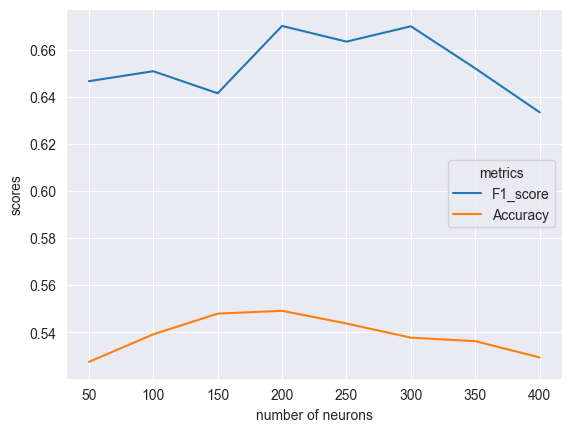

In [33]:
# plot changes in F1 score and accuracy according to the number of neurons.
n_layers = []
scores = []
metrics= []
for idx, result in enumerate(results_diff_n_neurons):
    n_layers.append(result['name'].split('-')[1])
    scores.append(result['f1_score'])
    metrics.append('F1_score')
    n_layers.append(result['name'].split('-')[1])
    scores.append(result['accuracy'])
    metrics.append('Accuracy')

df_layers = pd.DataFrame({'number of neurons': n_layers, 'scores': scores, 'metrics': metrics})
sns.lineplot(data=df_layers, x='number of neurons', y='scores', hue='metrics')

#### 2. Different number of hidden layers

In [27]:
# determine layers with different numbers of hidden layers (2, 3, 4, 5, 6)
layers_dict_list2 = [
    {
        'name': '128-50-50-10',
        'layers': [
            LinearLayer(128,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,10),
            SoftMaxLayer()
        ]
    },
    {
        'name': '128-50-50-50-10',
        'layers': [
            LinearLayer(128,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,10),
            SoftMaxLayer()
        ]
    },
    {
        'name': '128-50-50-50-50-10',
        'layers': [
            LinearLayer(128,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,10),
            SoftMaxLayer()
        ]
    },
    {
        'name': '128-50-50-50-50-50-10',
        'layers': [
            LinearLayer(128,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,10),
            SoftMaxLayer()
        ]
    },
    {
        'name': '128-50-50-50-50-50-10',
        'layers': [
            LinearLayer(128,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,50),
            BatchNormalizationLayer(50),
            ReLULayer(),
            DropOutLayer(dropout_ratio=0.1),
            LinearLayer(50,10),
            SoftMaxLayer()
        ]
    },
]

results_diff_n_layers = []
models_diff_n_layers= []

for layers_dict in layers_dict_list2:
    # print name of model (e.g. 128-150-150-10)
    print('[{:}]'.format(layers_dict['name']))

    # create and store a model
    models_diff_n_layers.append({
        'name': layers_dict['name'],
        'model': MLP(layers=layers_dict['layers'])})

    # train a model
    models_diff_n_layers[-1]['model'].train(x_train=x_train, y_train=y_train.flatten(), x_valid=x_valid, y_valid=y_valid.flatten(), epochs=500,
                                optimizer="momentum", learning_rate=0.1, momentum=0.9, weight_decay=0.1, patience=15, verbose=1)

    # make a prediction on test dataset and store result
    pred = models_diff_n_layers[-1]['model'].predict(x_test)
    results_diff_n_layers.append({'name': layers_dict['name'],
                    'loss': CrossEntropyLoss(models_diff_n_layers[-1]['model'], pred, y_test.flatten()).get_loss(),
                    'accuracy': np.mean(pred.argmax(1) == y_test.flatten()),
                    'f1_score': f1_score(y_test.flatten(), pred.argmax(1))})

[128-50-50-10]
best at epoch 68, train_loss: 1.38570720, train_acc: 0.49952500, valid_loss: 1.35386564, valid_acc: 0.51300000
[128-50-50-50-10]
best at epoch 87, train_loss: 1.38891495, train_acc: 0.50525000, valid_loss: 1.35718972, valid_acc: 0.52050000
[128-50-50-50-50-10]
best at epoch 85, train_loss: 1.41132508, train_acc: 0.49802500, valid_loss: 1.38252132, valid_acc: 0.51540000
[128-50-50-50-50-50-10]
best at epoch 112, train_loss: 1.40741412, train_acc: 0.50350000, valid_loss: 1.39119061, valid_acc: 0.51870000
[128-50-50-50-50-50-10]
best at epoch 91, train_loss: 1.44020696, train_acc: 0.49257500, valid_loss: 1.43438977, valid_acc: 0.51010000


In [38]:
for result in results_diff_n_layers:
    print(result)

{'name': '128-50-50-10', 'loss': 1.3414637226962098, 'accuracy': 0.5278, 'f1_score': 0.6522157996146436}
{'name': '128-50-50-50-10', 'loss': 1.3551507780350782, 'accuracy': 0.5203, 'f1_score': 0.6286876907426246}
{'name': '128-50-50-50-50-10', 'loss': 1.376153175440409, 'accuracy': 0.5143, 'f1_score': 0.6478048780487805}
{'name': '128-50-50-50-50-50-10', 'loss': 1.3860635167513349, 'accuracy': 0.5195, 'f1_score': 0.6204453441295545}
{'name': '128-50-50-50-50-50-10', 'loss': 1.4314407377115517, 'accuracy': 0.5086, 'f1_score': 0.6121856866537717}


<Axes: xlabel='number of layers', ylabel='scores'>

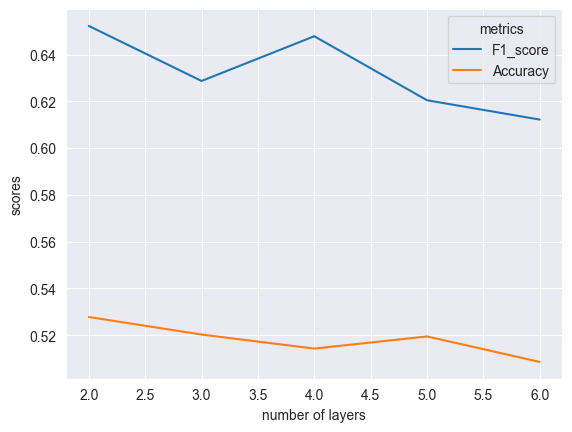

In [34]:
# plot changes in F1 score and accuracy according to the number of hidden layers.
n_layers = []
scores = []
metrics= []
for idx, result in enumerate(results_diff_n_layers):
    n_layers.append(idx+2)
    scores.append(result['f1_score'])
    metrics.append('F1_score')
    n_layers.append(idx+2)
    scores.append(result['accuracy'])
    metrics.append('Accuracy')

df_layers = pd.DataFrame({'number of layers': n_layers, 'scores': scores, 'metrics': metrics})
sns.lineplot(data=df_layers, x='number of layers', y='scores', hue='metrics')

#### 3. try different parameters of momentum

In [48]:
# try different parameters of momentum

p_list = [
    {'lr': 0.1, 'momentum': 0.9, 'wd': 0.1},
    {'lr': 0.01, 'momentum': 0.9, 'wd': 0.1},
    {'lr': 0.001, 'momentum': 0.9, 'wd': 0.1},
    {'lr': 0.1, 'momentum': 0.1, 'wd': 0.1},
    {'lr': 0.1, 'momentum': 0.5, 'wd': 0.1},
    {'lr': 0.1, 'momentum': 0.9, 'wd': 0.1},
    {'lr': 0.1, 'momentum': 0.9, 'wd': 0.1},
    {'lr': 0.1, 'momentum': 0.9, 'wd': 0.25},
    {'lr': 0.1, 'momentum': 0.9, 'wd': 0.5},
]

for p in p_list:
    # create a model
    myMLP = MLP(layers=[LinearLayer(128,30),
                        BatchNormalizationLayer(30),
                        ReLULayer(),
                        DropOutLayer(dropout_ratio=0.1),
                        LinearLayer(30,30),
                        BatchNormalizationLayer(30),
                        ReLULayer(),
                        DropOutLayer(dropout_ratio=0.1),
                        LinearLayer(30,10),
                        SoftMaxLayer()])

    # train the model with different parameters of momentum
    myMLP.train(x_train=x_train, y_train=y_train.flatten(), x_valid=x_valid, y_valid=y_valid.flatten(), epochs=500,
                optimizer="momentum", learning_rate=p['lr'], momentum=p['momentum'], weight_decay=p['wd'], patience=10, verbose=1)
    pred = myMLP.predict(x_test)
    print('loss: {:.4f}, accuracy: {:.4f}, f1: {:.4f}'.format(
        CrossEntropyLoss(myMLP, pred, y_test.flatten()).get_loss(),
        np.mean(pred.argmax(1) == y_test.flatten()),
        f1_score(y_test.flatten(), pred.argmax(1))))

best at epoch 66, train_loss: 1.51180517, train_acc: 0.45750000, valid_loss: 1.44547687, valid_acc: 0.48450000
loss: 1.4319, accuracy: 0.4960, f1: 0.6222
best at epoch 123, train_loss: 1.51188287, train_acc: 0.45805000, valid_loss: 1.45539315, valid_acc: 0.48940000
loss: 1.4474, accuracy: 0.4882, f1: 0.6053
best at epoch 289, train_loss: 1.60494930, train_acc: 0.42397500, valid_loss: 1.54578096, valid_acc: 0.45280000
loss: 1.5281, accuracy: 0.4639, f1: 0.5886
best at epoch 47, train_loss: 1.51991650, train_acc: 0.45535000, valid_loss: 1.45321684, valid_acc: 0.48060000
loss: 1.4306, accuracy: 0.4953, f1: 0.6128
best at epoch 62, train_loss: 1.50642401, train_acc: 0.46085000, valid_loss: 1.43961211, valid_acc: 0.49110000
loss: 1.4324, accuracy: 0.4920, f1: 0.5838
best at epoch 86, train_loss: 1.50411506, train_acc: 0.46252500, valid_loss: 1.43643765, valid_acc: 0.48950000
loss: 1.4228, accuracy: 0.4972, f1: 0.6065
best at epoch 57, train_loss: 1.51269996, train_acc: 0.45975000, valid_los

#### 4. try different values of weight decay

In [49]:
# try 0 of weight decay
# create a model
myMLP = MLP(layers=[LinearLayer(128,30),
                    BatchNormalizationLayer(30),
                    ReLULayer(),
                    DropOutLayer(dropout_ratio=0.1),
                    LinearLayer(30,30),
                    BatchNormalizationLayer(30),
                    ReLULayer(),
                    DropOutLayer(dropout_ratio=0.1),
                    LinearLayer(30,10),
                    SoftMaxLayer()])

# train the model with different parameters of momentum
myMLP.train(x_train=x_train, y_train=y_train.flatten(), x_valid=x_valid, y_valid=y_valid.flatten(), epochs=500,
            optimizer="momentum", learning_rate=0.1, momentum=0.9, weight_decay=0, patience=10, verbose=1)
pred = myMLP.predict(x_test)
print('loss: {:.4f}, accuracy: {:.4f}, f1: {:.4f}'.format(
    CrossEntropyLoss(myMLP, pred, y_test.flatten()).get_loss(),
    np.mean(pred.argmax(1) == y_test.flatten()),
    f1_score(y_test.flatten(), pred.argmax(1))))

best at epoch 44, train_loss: 1.51814892, train_acc: 0.45492500, valid_loss: 1.44297630, valid_acc: 0.48840000
loss: 1.4470, accuracy: 0.4872, f1: 0.6161


#### 5. try different parameters of adam

In [57]:
# try different parameters of adam

p_list = [
    {'lr': 0.1,  'wd': 0.1},
    {'lr': 0.01,  'wd': 0.1},
    {'lr': 0.001, 'wd': 0.1},
    {'lr': 0.001, 'wd': 0},
    {'lr': 0.001, 'wd': 0.1},
    {'lr': 0.001,  'wd': 0.25},
    {'lr': 0.001,  'wd': 0.5},
]

for p in p_list:
    # create a model
    myMLP = MLP(layers=[LinearLayer(128,30),
                        BatchNormalizationLayer(30),
                        ReLULayer(),
                        DropOutLayer(dropout_ratio=0.1),
                        LinearLayer(30,30),
                        BatchNormalizationLayer(30),
                        ReLULayer(),
                        DropOutLayer(dropout_ratio=0.1),
                        LinearLayer(30,10),
                        SoftMaxLayer()])

    # train the model with different parameters of momentum
    myMLP.train(x_train=x_train, y_train=y_train.flatten(), x_valid=x_valid, y_valid=y_valid.flatten(), epochs=500,
                optimizer="adam", learning_rate=p['lr'], weight_decay=p['wd'], patience=10, verbose=1)
    pred = myMLP.predict(x_test)
    print('loss: {:.4f}, accuracy: {:.4f}'.format(
        CrossEntropyLoss(myMLP, pred, y_test.flatten()).get_loss(),
        np.mean(pred.argmax(1) == y_test.flatten())))

best at epoch 4, train_loss: 1.81796088, train_acc: 0.34867500, valid_loss: 1.68545795, valid_acc: 0.39250000
loss: 2.5186, accuracy: 0.1000
best at epoch 60, train_loss: 1.62956507, train_acc: 0.42000000, valid_loss: 1.55755919, valid_acc: 0.44710000
loss: 1.6576, accuracy: 0.4164
best at epoch 248, train_loss: 1.64300820, train_acc: 0.41572500, valid_loss: 1.60350397, valid_acc: 0.43090000
loss: 1.5908, accuracy: 0.4387
best at epoch 305, train_loss: 1.62948644, train_acc: 0.41580000, valid_loss: 1.58825260, valid_acc: 0.43560000
loss: 1.5752, accuracy: 0.4422
best at epoch 213, train_loss: 1.66613525, train_acc: 0.40577500, valid_loss: 1.62232557, valid_acc: 0.42040000
loss: 1.6154, accuracy: 0.4379
best at epoch 225, train_loss: 1.66006643, train_acc: 0.40907500, valid_loss: 1.60776406, valid_acc: 0.43160000
loss: 1.5968, accuracy: 0.4429
best at epoch 238, train_loss: 1.65300127, train_acc: 0.41027500, valid_loss: 1.61156716, valid_acc: 0.42640000
loss: 1.6015, accuracy: 0.4406


#### 6. try a model with batch normalization and other model without batch normalization

In [58]:
# try without batch normalization
myMLP = MLP(layers=[LinearLayer(128,30),
                    ReLULayer(),
                    DropOutLayer(dropout_ratio=0.1),
                    LinearLayer(30,30),
                    ReLULayer(),
                    DropOutLayer(dropout_ratio=0.1),
                    LinearLayer(30,10),
                    SoftMaxLayer()])

# train the model with different parameters of momentum
myMLP.train(x_train=x_train, y_train=y_train.flatten(), x_valid=x_valid, y_valid=y_valid.flatten(), epochs=500,
            optimizer="momentum", learning_rate=0.1, momentum=0.9, weight_decay=0.1, patience=10, verbose=1)
pred = myMLP.predict(x_test)
print('loss: {:.4f}, accuracy: {:.4f}'.format(
    CrossEntropyLoss(myMLP, pred, y_test.flatten()).get_loss(),
    np.mean(pred.argmax(1) == y_test.flatten())))

# try with batch normalization
myMLP = MLP(layers=[LinearLayer(128,30),
                    BatchNormalizationLayer(30),
                    ReLULayer(),
                    DropOutLayer(dropout_ratio=0.1),
                    LinearLayer(30,30),
                    BatchNormalizationLayer(30),
                    ReLULayer(),
                    DropOutLayer(dropout_ratio=0.1),
                    LinearLayer(30,10),
                    SoftMaxLayer()])

# train the model with different parameters of momentum
myMLP.train(x_train=x_train, y_train=y_train.flatten(), x_valid=x_valid, y_valid=y_valid.flatten(), epochs=500,
            optimizer="momentum", learning_rate=0.1, momentum=0.9, weight_decay=0.1, patience=10, verbose=1)
pred = myMLP.predict(x_test)
print('loss: {:.4f}, accuracy: {:.4f}'.format(
    CrossEntropyLoss(myMLP, pred, y_test.flatten()).get_loss(),
    np.mean(pred.argmax(1) == y_test.flatten())))

best at epoch 50, train_loss: 1.54335072, train_acc: 0.44757500, valid_loss: 1.51256092, valid_acc: 0.46790000
loss: 1.5059, accuracy: 0.4712
best at epoch 82, train_loss: 1.50587403, train_acc: 0.45952500, valid_loss: 1.44595633, valid_acc: 0.48220000
loss: 1.4282, accuracy: 0.4981


#### 7. try different dropout ratio

In [59]:
# try different dropout ratio with the model (2 hidden layers, 30 neurons)
ratio_list = [0, 0.1, 0.3, 0.5]

for ratio in ratio_list:
    # create a model
    myMLP = MLP(layers=[LinearLayer(128,30),
                        BatchNormalizationLayer(30),
                        ReLULayer(),
                        DropOutLayer(dropout_ratio=ratio),
                        LinearLayer(30,30),
                        BatchNormalizationLayer(30),
                        ReLULayer(),
                        DropOutLayer(dropout_ratio=ratio),
                        LinearLayer(30,10),
                        SoftMaxLayer()])

    # train the model with different parameters of momentum
    myMLP.train(x_train=x_train, y_train=y_train.flatten(), x_valid=x_valid, y_valid=y_valid.flatten(), epochs=500,
                optimizer="momentum", learning_rate=0.1, momentum=0.9, weight_decay=0.1, patience=10, verbose=1)
    pred = myMLP.predict(x_test)
    print('loss: {:.4f}, accuracy: {:.4f}'.format(
        CrossEntropyLoss(myMLP, pred, y_test.flatten()).get_loss(),
        np.mean(pred.argmax(1) == y_test.flatten())))

best at epoch 43, train_loss: 1.37334515, train_acc: 0.50767500, valid_loss: 1.38971632, valid_acc: 0.50630000
loss: 1.3956, accuracy: 0.5003
best at epoch 21, train_loss: 1.63894332, train_acc: 0.40997500, valid_loss: 1.57728749, valid_acc: 0.45060000
loss: 1.5645, accuracy: 0.4637
best at epoch 30, train_loss: 1.79409704, train_acc: 0.35412500, valid_loss: 1.83770460, valid_acc: 0.42760000
loss: 1.8161, accuracy: 0.4314
best at epoch 28, train_loss: 1.95680127, train_acc: 0.27392500, valid_loss: 2.09952925, valid_acc: 0.36300000
loss: 2.1097, accuracy: 0.3505


In [9]:
# try different dropout ratio with the model (2 hidden layers, 200 neurons)
ratio_list = [0, 0.1, 0.3, 0.5]

for ratio in ratio_list:
    # create a model
    myMLP = MLP(layers=[LinearLayer(128,200),
                        BatchNormalizationLayer(200),
                        ReLULayer(),
                        DropOutLayer(dropout_ratio=ratio),
                        LinearLayer(200,200),
                        BatchNormalizationLayer(200),
                        ReLULayer(),
                        DropOutLayer(dropout_ratio=ratio),
                        LinearLayer(200,10),
                        SoftMaxLayer()])

    # train the model with different parameters of momentum
    myMLP.train(x_train=x_train, y_train=y_train.flatten(), x_valid=x_valid, y_valid=y_valid.flatten(), epochs=500,
                optimizer="momentum", learning_rate=0.1, momentum=0.9, weight_decay=0.1, patience=10, verbose=1)
    pred = myMLP.predict(x_test)
    print('loss: {:.4f}, accuracy: {:.4f}'.format(
        CrossEntropyLoss(myMLP, pred, y_test.flatten()).get_loss(),
        np.mean(pred.argmax(1) == y_test.flatten())))

best at epoch 8, train_loss: 1.19597432, train_acc: 0.57392500, valid_loss: 1.35794570, valid_acc: 0.52200000
loss: 1.3540, accuracy: 0.5282
best at epoch 25, train_loss: 1.11739712, train_acc: 0.60110000, valid_loss: 1.28766630, valid_acc: 0.54430000
loss: 1.2925, accuracy: 0.5400
best at epoch 54, train_loss: 1.24800487, train_acc: 0.55495000, valid_loss: 1.36364978, valid_acc: 0.53720000
loss: 1.3632, accuracy: 0.5399
best at epoch 90, train_loss: 1.39553125, train_acc: 0.50067500, valid_loss: 1.63874788, valid_acc: 0.50040000
loss: 1.6162, accuracy: 0.5085


## Train, predict and evaluate of the best model

In [10]:
# create a model
myMLP = MLP(layers=[LinearLayer(128,200),
                    BatchNormalizationLayer(200),
                    ReLULayer(),
                    DropOutLayer(dropout_ratio=0.1),
                    LinearLayer(200,200),
                    BatchNormalizationLayer(200),
                    ReLULayer(),
                    DropOutLayer(dropout_ratio=0.1),
                    LinearLayer(200,10),
                    SoftMaxLayer()])

# train and test the model
myMLP.train(x_train=x_train, y_train=y_train.flatten(), x_valid=x_valid, y_valid=y_valid.flatten(),
            optimizer="momentum", learning_rate=0.1, weight_decay=0.1, patience=15, verbose=3)

# predict on test dataset and print result
pred = myMLP.predict(x_test)
print('loss: {:.4f}, accuracy: {:.4f}, f1: {:.4f}'.format(
    CrossEntropyLoss(myMLP, pred, y_test.flatten()).get_loss(),
    np.mean(pred.argmax(1) == y_test.flatten()),
    f1_score(y_test.flatten(), pred.argmax(1))))

epoch 1: train_ce_Loss=1.76859950, train_acc=0.37070000, valid_ce_loss=1.58098227, valid_acc=0.43560000, patience=0
epoch 2: train_ce_Loss=1.58502643, train_acc=0.43325000, valid_ce_loss=1.50679064, valid_acc=0.46310000, patience=0
epoch 3: train_ce_Loss=1.50223733, train_acc=0.46350000, valid_ce_loss=1.45310727, valid_acc=0.47860000, patience=0
epoch 4: train_ce_Loss=1.45982771, train_acc=0.47697500, valid_ce_loss=1.43357981, valid_acc=0.48270000, patience=0
epoch 5: train_ce_Loss=1.41224673, train_acc=0.49727500, valid_ce_loss=1.40272334, valid_acc=0.49590000, patience=0
epoch 6: train_ce_Loss=1.38514057, train_acc=0.50522500, valid_ce_loss=1.38428047, valid_acc=0.50350000, patience=0
epoch 7: train_ce_Loss=1.35435459, train_acc=0.51637500, valid_ce_loss=1.36221030, valid_acc=0.51340000, patience=0
epoch 8: train_ce_Loss=1.33311922, train_acc=0.52247500, valid_ce_loss=1.35606473, valid_acc=0.51900000, patience=0
epoch 9: train_ce_Loss=1.31279698, train_acc=0.52925000, valid_ce_loss=1

In [11]:
pred = myMLP.predict(x_test)
y_actu = pd.Series(y_test.reshape(y_test.shape[0]), name='Actual')
y_pred = pd.Series(pred.argmax(1), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion_norm = df_confusion.div(df_confusion.sum(axis=1), axis="index")
df_confusion_norm

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,0.639,0.024,0.060,0.014,0.040,0.016,0.033,0.022,0.111,0.041
1,0.032,0.624,0.013,0.020,0.017,0.007,0.032,0.021,0.070,0.164
2,0.069,0.011,0.390,0.074,0.166,0.062,0.133,0.055,0.015,0.025
3,0.026,0.015,0.075,0.349,0.084,0.184,0.153,0.060,0.016,0.038
4,0.033,0.006,0.112,0.044,0.520,0.043,0.138,0.073,0.021,0.010
5,0.020,0.002,0.079,0.234,0.075,0.400,0.080,0.086,0.009,0.015
6,0.005,0.010,0.067,0.066,0.084,0.039,0.695,0.018,0.008,0.008
7,0.031,0.006,0.042,0.058,0.097,0.072,0.035,0.611,0.012,0.036
8,0.102,0.054,0.017,0.036,0.029,0.014,0.020,0.019,0.661,0.048


In [14]:
print('accuracy:', np.mean(pred.argmax(1) == y_test.flatten()))
print('f1 score:', f1_score(y_actu, y_pred))

accuracy: 0.5493
f1 score: 0.6589229144667371


<Axes: xlabel='Predicted', ylabel='Actual'>

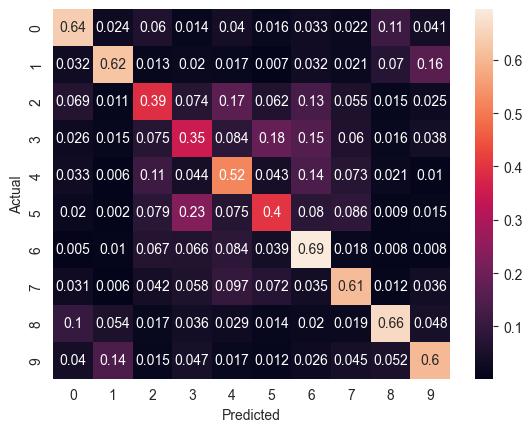

In [15]:
sns.heatmap(df_confusion_norm, annot=True)